General template for customized tearsheet that generates the following plots:

>>Option Chain  
>>Payoff Function  
>>Projection Charts  
>>Tangency Portfolio  
>>Standard Deviation Calculator  
>>After Hours Analysis  
>>Dividend Analysis  
>>Net Burn Rate  
>>Profitability Ratios  

New Sentiment Report

First set working paths and file names:

In [ ]:
#Set path parameters and import libraries
import pandas as pd
import os

# Set path parameters
working_directory = 'F:\\inputs\\masterlists'
file_name = "earnings.csv"  # Ensure the file extension is included

# Concatenate using os.path.join for proper path handling
full_path = os.path.join(working_directory, file_name)

# Read the CSV file using pandas
df = pd.read_csv(full_path)

prind(df


Option Screener to Create DataFrame with Option Chains

In [2]:
#Run list through option chain screener
#Screen through price history
import pandas as pd
import datetime as dt
from config import CONSUMER_KEY, REDIRECT_URI, JSON_PATH
from td.client import TDClient
import lesl
import pprint
import datetime as dt
import time
import os
import lesl
import config

# Set your rate limit (e.g., 10 requests per second)
rate_limit = 2  
request_interval = 1.0 / rate_limit

last_request_time = None

# Before each API call:
current_time = time.time()
if last_request_time is not None:
    elapsed = current_time - last_request_time
    if elapsed < request_interval:
        time.sleep(request_interval - elapsed)
last_request_time = current_time



get_first_friday = dt.date.today()
while get_first_friday.weekday() != 4:
    get_first_friday += dt.timedelta(1)
two_weeks = dt.timedelta(days=14)
two_weeks_from_nearest_friday = get_first_friday + two_weeks
two_weeks_from_nearest_friday_formatted = two_weeks_from_nearest_friday.strftime("%Y-%m-%d")

#Create a new instance of the client
TDSession = TDClient(
    client_id= CONSUMER_KEY,
    redirect_uri= REDIRECT_URI,
    credentials_path= JSON_PATH
)


#optional date variables to import from listener.py
#start = lb.s_date_list
#end = lb.e_date_list
#dates = pd.date_range(start, end)
#df1 = pd.DataFrame(index=dates)

#STOCK DATAFRAME (for buy function only, commended out but kept to preserve as a backup)
#url = "https://www.sec.gov/include/ticker.txt"
#First source of stocks is url containing thousands of stocks, so it is disabled by default 
#s = pd.read_csv(url, sep = '\t', names=["Symbol", "cusip"])
# Set path parameters
working_directory = 'F:\\inputs\\masterlists'
file_name = "earningscurrentday.csv"  # Ensure the file extension is included

# Concatenate using os.path.join for proper path handling
full_path = os.path.join(working_directory, file_name)

# Read the CSV file using pandas
df = pd.read_csv(full_path)
#Create Symbols From Dataset
Symbols = df['symbol'].tolist()
target_symbols_long = []
target_symbols_short = []
# iterate over each symbol
dfs =pd.DataFrame()
def stock_screen():
    for i in Symbols:
        try:
            stock = TDSession.get_price_history(symbol=i, period_type='month', period= 1, frequency_type='daily', frequency=1)
        except:
            print("limit reached, moving on...")
            pass
        try:
            stock_df = pd.DataFrame(stock['candles'])
            df2 = pd.DataFrame()
            df2["Date"] = pd.to_datetime(stock_df['datetime'], unit='ms')
            df2["Close"] = stock_df['close']
            df2["Volume"] = stock_df['volume']
            df2["MA9"] = stock_df['close'].ewm(span=9).mean()
            df2["Symbol"] =stock['symbol']
            bool_long = df2["MA9"].iloc[-1] < df2["Close"].iloc[-1]  ##create Boolean to filter out stocks to go long on.
            if bool_long == True:
                target_list_long = stock['symbol']
                target_symbols_long.append(target_list_long)
                print("Stock ", i, "is within buying parameters. Dataframe: " , "\n")
                print(df2.tail(1))
            else:
                print("Stock", i, "is not within buying parameters")


            bool_short = df2["MA9"].iloc[-1] > df2["Close"].iloc[-1]  ##create second boolean to filter out stocks to short.
            if bool_short == True:
                target_list_short = stock['symbol']
                target_symbols_short.append(target_list_short)
                print("Stock ", i, "is within selling parameters. Dataframe: " , "\n")
                print(df2.tail(1))
            else:
                print("Stock", i, "is not within selling parameters")   
        except KeyError:
            print("Not possible to find price history for ", i, "...moving on")


        except KeyError as err:
            print("No owned options to sell at the moment")
        
        


try:
    for i in target_symbols_short:
        quotes_response_s = TDSession.get_quotes(instruments = [i])
        quotes_df_s = quotes_response_s[i]['bidPrice']
    for i in target_symbols_long:
        quotes_response_o = TDSession.get_quotes(instruments = [i])
        quotes_df_o = quotes_response_o[i]['bidPrice']
except KeyError as err:
    print("No symbols warranting selling")
    

    
pd.set_option("display.max_colwidth", None)

pd.option_context('display.max_seq_items', None)

target_symbols_calls = []
target_symbols_puts = []

# Initialize the master dataframe outside of your function
master_df = pd.DataFrame()
o_df = pd.DataFrame()
o_df_p =pd.DataFrame()

def get_optionchainc():
        global master_df
        o_df = pd.DataFrame()
        o_df_p =pd.DataFrame()
        for i in target_symbols_long:
            o_dict1 = TDSession.get_options_chain(option_chain={'symbol': i, 'strikeCount': 1, get_first_friday: two_weeks_from_nearest_friday_formatted})
            o_df1 = pd.DataFrame.from_dict(o_dict1)
            o_series1 = o_df1['callExpDateMap']
            o_dict2 = o_series1.to_dict()
            o_df2 = pd.DataFrame(o_dict1, columns=["Sym",'E Date', 'S Price' , 'A Price', 'IV'])
            o_df2["Sym"] = o_df1['symbol']
            o_df2["E Date"] =  o_df1.index
            o_df3 = pd.DataFrame.from_dict(o_dict2, orient="index").stack().to_frame()
            # to break out the lists into columns
            o_df4 = pd.DataFrame(o_df3[0].values.tolist(), index=o_df3.index)
            o_array = o_df4.values
            o_dict3 = dict(enumerate(o_array.flatten(),))
            asklists = []
            volatilitys = []
            strikeprices = []
            volumec = []
            deltac = []
            try:
                for row in o_dict3:
                    a = o_dict3[row]['ask']
                    asklists.append(a)
                    v = o_dict3[row]['volatility']
                    volatilitys.append(v)
                    st = o_dict3[row]['strikePrice']
                    strikeprices.append(st)
                    volc = o_dict3[row]['totalVolume']
                    volumec.append(volc)
                    deltaca = o_dict3[row]['delta']
                    deltac.append(deltaca)
                
                o_df2["S Price"] = strikeprices
                o_df2["A Price"] = asklists
                o_df2["IV"] = volatilitys  
                o_df2["Vol"] = volumec  
                o_df2["Delta"] = deltac
                o_df2_o = o_df2.loc[o_df2["A Price"] < .6]
                # After processing each symbol's data and storing it in o_df2_o
                master_df = pd.concat([master_df, o_df2_o], ignore_index=True)
                o_df._append(o_df2_o)
                target_list_o = o_df2_o['Sym']
                target_symbols_calls.append(target_list_o)
                if o_df2_o.empty:             
                    print("Call options for ", i, " are not within buying parameters")
                else:
                    print("Call options for ", i, " are: ", "\n", o_df2_o)
            except KeyError:
                print("There are no call option contracts able to be found for symbol ", i, "...moving on")


def get_optionchainp():
        global master_df
        for i in target_symbols_short:
            o_dict1p = TDSession.get_options_chain(option_chain={'symbol': i, 'strikeCount': 1, get_first_friday: two_weeks_from_nearest_friday_formatted})
            o_df1p = pd.DataFrame.from_dict(o_dict1p)
            o_series1p = o_df1p['putExpDateMap']
            o_dict2p = o_series1p.to_dict()
            o_df2p = pd.DataFrame(o_dict1p, index=None, columns=["Sym",'E Date', 'S Price' , 'A Price', 'IV'])
            o_df2p["Sym"] = o_df1p['symbol']
            o_df2p["E Date"] =  o_df1p.index
            o_df3p = pd.DataFrame.from_dict(o_dict2p, orient="index").stack().to_frame()
            # to break out the lists into columns
            o_df4p = pd.DataFrame(o_df3p[0].values.tolist(), index=o_df3p.index)
            o_arrayp = o_df4p.values
            o_dict3p = dict(enumerate(o_arrayp.flatten(),))
            asklists = []
            volatilitys = []
            strikeprices = []
            volumep = []
            deltap = []
            try:
                for row in o_dict3p:
                    a = o_dict3p[row]['ask']
                    asklists.append(a)
                    v = o_dict3p[row]['volatility']
                    volatilitys.append(v)
                    st = o_dict3p[row]['strikePrice']
                    strikeprices.append(st)
                    volp = o_dict3p[row]['totalVolume']
                    volumep.append(volp)
                    deltacb = o_dict3p[row]['delta']
                    deltap.append(deltacb)
                o_df2p["S Price"] = strikeprices
                o_df2p["A Price"] = asklists
                o_df2p["IV"] = volatilitys
                o_df2p["Vol"] = volumep
                o_df2p["Delta"] = deltap    
                o_df2_p = o_df2p[o_df2p["A Price"] < .6]
                # After processing each symbol's data and storing it in o_df2_p
                master_df = pd.concat([master_df, o_df2_p], ignore_index=True)
                o_df_p.join(o_df2_p)
                target_list_o = o_df2_p['Sym']
                target_symbols_puts.append(target_list_o)
                if o_df2_p.empty:             
                    print("Put options for ", i, " are not within buying parameters")
                else:
                    print("Put options for ", i, " are: ", "\n", o_df2_p)
                #debug API key values
                #print(o_dict3p)
            except KeyError:
                print("No put option contracts found for symbol ", i, "...moving on")

def print_sell_log():
    global master_df
    print("Initializing option chain generator...")
    stock_screen()
    try:
        get_optionchainc()
    
    except:
        print("No call options in target dataframes")

    try:
    
        get_optionchainp()
    
    except:
        print("No put options in target dataframes")
    


print_sell_log()
print(master_df)
#print(o_df, o_df_p)
master_df.to_csv("F:\inputs\options\chainregistry.csv")

Initializing option chain generator...
Stock NCLH is not within buying parameters
Stock  NCLH is within selling parameters. Dataframe:  

                  Date  Close    Volume        MA9 Symbol
20 2024-02-26 06:00:00  15.93  15361714  16.302299   NCLH
Stock  LOW is within buying parameters. Dataframe:  

                  Date   Close   Volume         MA9 Symbol
20 2024-02-26 06:00:00  231.32  2928025  228.513666    LOW
Stock LOW is not within selling parameters
Stock  AZO is within buying parameters. Dataframe:  

                  Date    Close  Volume          MA9 Symbol
20 2024-02-26 06:00:00  2770.46  221922  2745.878761    AZO
Stock AZO is not within selling parameters
Stock AEP is not within buying parameters
Stock  AEP is within selling parameters. Dataframe:  

                  Date  Close   Volume        MA9 Symbol
20 2024-02-26 06:00:00  80.77  4705321  80.876323    AEP
Stock TREE is not within buying parameters
Stock  TREE is within selling parameters. Dataframe:  

    

Option Payoff Diagram

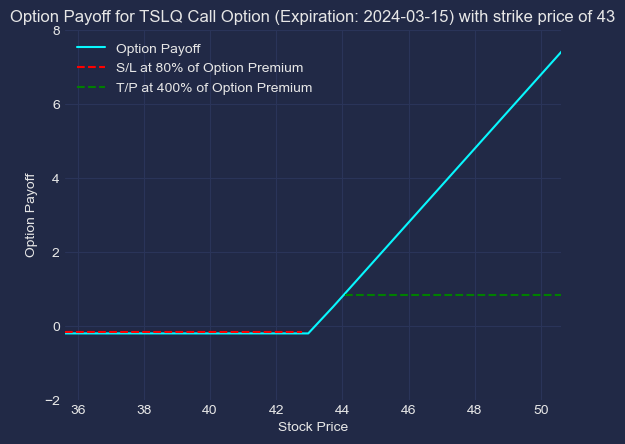

In [3]:
#Option Payoff Diagram
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import mplcyberpunk



# Function to calculate the call option payoff
def call_option_payoff(stock_price, strike_price, option_premium):
    if stock_price < strike_price:
        return -option_premium
    else:
        return stock_price - strike_price - option_premium

# Function to calculate the put option payoff
def put_option_payoff(stock_price, strike_price, option_premium):
    if stock_price < strike_price:
        return max(strike_price - stock_price - option_premium, -option_premium)
    else:
        return -option_premium

# Function to plot the option payoff diagram
def plot_option_payoff(call_or_put, expiration_date, stock_ticker, strike_price, option_premium):
    # Get the last closing price of the stock from Yahoo Finance
    stock_info = yf.Ticker(stock_ticker).history(period='1d')
    current_price = stock_info['Close'][0]

    # Create a range of stock prices
    stock_prices = np.linspace(current_price * 0.5, current_price * 2.5, 100)

    # Calculate option payoffs based on call or put
    if call_or_put == "call":
        option_payoffs = [call_option_payoff(price, strike_price, option_premium) for price in stock_prices]
    elif call_or_put == "put":
        option_payoffs = [put_option_payoff(price, strike_price, option_premium) for price in stock_prices]

    # Create the figure and axis objects
    fig, ax = plt.subplots()

    # Set the axis limits
    ax.set_xlim([current_price *  0.95, current_price * 1.35])
    #ax.set_ylim([-1, max(option_payoffs) ])
    ax.set_ylim([-2, 8])
    # Set the axis labels
    ax.set_xlabel('Stock Price')
    ax.set_ylabel('Option Payoff')

    # Set the title
    ax.set_title(f'Option Payoff for {stock_ticker} {call_or_put.capitalize()} Option (Expiration: {expiration_date}) with strike price of {strike_price}')

    # Plot the option payoff function
    ax.plot(stock_prices, option_payoffs, label='Option Payoff')

    # Add horizontal red line at 80% of the option_premium value to the left of the option payoff
    if call_or_put == "call":
        ax.axhline(y=-0.8 * option_premium, color='red', linestyle='--', label='S/L at 80% of Option Premium', xmin=0, xmax=(strike_price - current_price * 0.5) / (current_price * adjust_red_call - current_price * 0.5))
    else:
        # Flip the horizontal red line for a put option
        ax.axhline(y=-0.8 * option_premium, color='red', linestyle='--', label='S/L at 80% of Option Premium', xmin=(strike_price - current_price * 0.50) / (current_price * adjust_red_put - current_price * 0.5), xmax=1)

    # Find the index where the option payoff is equal to the green line y value for calls
    start_index_call = np.argmin(np.abs(np.array(option_payoffs) - 85  * option_premium))

    # Find the index where the option payoff is equal to the green line y value for puts
    start_index_put = next(i for i, payoff in enumerate(option_payoffs) if payoff >= 0)
    
    
    # Find the index where the put option payoff crosses the y-value of 0
    end_index_put = np.argmin(np.abs(np.array(option_payoffs[start_index_put:]) - 5 * option_premium))



    # Calculate the relative position for xmax of the green line
    xmax_relative_position = end_index_put / (len(stock_prices))


    # Add horizontal green line for a call option starting from the intersection point and ending at the maximum x-axis value
    if call_or_put == "call":
        ax.axhline(y=4 * option_premium, color='green', linestyle='--', label='T/P at 400% of Option Premium', xmin=start_index_call / (len(stock_prices) - 1), xmax=1)
    else:
    # Plot the green line for the put option if a valid intersection point is found
        if call_or_put == "put":
            # Ensure end_index_put is not the last element (which would imply no valid intersection)
            if end_index_put < len(option_payoffs) - 1:
                ax.axhline(y=2.5, color='green', linestyle='--', label='T/P at 400% of Option Premium', xmin=0, xmax=(strike_price - current_price * 0.50) / (current_price * 1.5 - current_price * 0.5))
        
        
    plt.style.use('cyberpunk')
    
    # Add legend to the plot
    ax.legend(loc='upper left')
    # Save the chart as a GIF file
    chart_filename = f'{stock_ticker}_Option_Payoff.png'
    #plt.savefig(chart_filename, format='png', bbox_inches='tight', pad_inches=0.1)

    plt.show()

# Request user input for option parameters
call_or_put = "call" #input("Call or put? Enter in lowercase letters: ")
expiration_date = "2024-03-15" #input('Enter the expiration date (YYYY-MM-DD): ')
stock_ticker = "TSLQ" #input('Enter the stock ticker: ')
strike_price =  43 #float(input('Enter the strike price: '))
option_premium = .21 #float(input('Enter the option premium: '))
adjust_red_call = 1.85
adjust_red_put = 1.25

# Plot the option payoff diagram based on user input
plot_option_payoff(call_or_put, expiration_date, stock_ticker, strike_price, option_premium)


Projection Charts and Tangency Portfolio Cells Under Wraps For Now

Compute Starndard Deviation

In [6]:
#Compute standard deviation for list

import pandas as pd

working_directory = 'F:\\inputs\\masterlists'
file_name = "earningscurrentday.csv"  # Ensure the file extension is included

# Concatenate using os.path.join for proper path handling
full_path = os.path.join(working_directory, file_name)

# Read the CSV file using pandas
df = pd.read_csv(full_path)
#Create Symbols From Dataset
Symbols = df['symbol'].tolist()

import yfinance as yf

def calculate_std_dev(stock_tickers):
    # Create an empty DataFrame to store results
    result_df = pd.DataFrame(columns=["Stock Ticker", "Standard Deviation", "Price Range min", "Price Range max", "Last Price"])

    # Iterate through each stock ticker
    for ticker in Symbols:
        try:
            # Download historical data using yfinance for the specified ticker
            data = yf.download(ticker, period="9d", progress=False)
            
            # Calculate the standard deviation of the closing prices
            std_dev = data["Close"].std()
            
            # Calculate the price range
            price_min = data["Close"].min() - std_dev
            price_max = data["Close"].max() + std_dev
            
            # Get the last closing price
            last_price = data["Close"].iloc[-1]
            
            # Append the result to the DataFrame
            result_df = result_df._append({"Stock Ticker": ticker, "Standard Deviation": std_dev, 
                                           "Price Range min": price_min, "Price Range max": price_max, 
                                           "Last Price": last_price}, ignore_index=True)
        except Exception as e:
            print(f"Error fetching data for {ticker}: {str(e)}")

    return result_df



if __name__ == "__main__":

    # Calculate standard deviation and other metrics
    result = calculate_std_dev(Symbols)
    
    # Save the result DataFrame to a CSV file
    result.to_csv('F:\\output\\afterhours_analysis\\earnings-test3.csv', index=False)  # This line saves the result DataFrame to a CSV file named 'result.csv' without including the index column.

    print(result)





  Stock Ticker  Standard Deviation  Price Range min  Price Range max  \
0         PLUG            0.318883         2.691117         4.278883   
1         FUBO            0.102713         1.667287         2.172713   
2          TDW            2.041656        65.918343        75.921654   
3         RDNT            0.485098        37.044901        39.435099   
4         RPID            0.050491         0.879509         1.150491   
5         INTT            0.222417        11.057582        12.312418   
6           AY            0.560670        17.239330        19.850671   
7         BDSX            0.045077         1.414923         1.625077   
8         PGRU            0.046286         3.313714         3.526286   
9          AEG            0.065384         5.634616         5.985384   

   Last Price  
0    3.530000  
1    2.070000  
2   70.029999  
3   37.860001  
4    1.100000  
5   11.680000  
6   17.959999  
7    1.540000  
8    3.480000  
9    5.920000  


Afterhours Analysis

In [7]:
#Additional After Hours Analyzer tool for top gainers and losers, calculates their min and max standard deviations
#From marketwatch get tickers, template
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Define the URL to scrape for after-hours stock data
url = 'https://www.marketwatch.com/tools/screener/after-hours'

# Make a GET request to the URL and store the response object
res = requests.get(url)

# Parse the HTML content of the response object with BeautifulSoup
soup = BeautifulSoup(res.text, 'html.parser')

# Extract the table rows that contain the after-hours stock data
rows = soup.select('.table__body tr')

# Initialize an empty set to store unique ticker symbols
unique_tickers = set()

# Initialize an empty list to store the after-hours stock data
after_hours_stocks = []

# Loop over the table rows and extract the data for each after-hours stock
for row in rows:
    cells = row.select('td')
    # Extract the cell contents and split on newline characters
    ticker = cells[0].text.strip().split('\n')[0]
    # Check if the ticker is already in the set
    if ticker not in unique_tickers:
        unique_tickers.add(ticker)  # Add the ticker to the set
        #print(f"Unique ticker: '{ticker}'")
        name = cells[1].text.strip()
        last_price = cells[2].text.strip()
        change = cells[3].text.strip()
        volume = cells[4].text.strip()
        after_hours_stocks.append({'Ticker': ticker, 'Name': name, 'Last Price': last_price, 'Change': volume, 'Volume': change})
    else:
        #print(f"Duplicate ticker: '{ticker}'")
        pass
# Convert the list of after-hours stock data into a pandas DataFrame
after_hours_df = pd.DataFrame(after_hours_stocks)

# Sort the DataFrame by the 'Last Price' column (assuming ascending order)
after_hours_df.sort_values(by='Last Price', inplace=True)

# Print the table of after-hours stocks
print(after_hours_df.to_string(index=False))

import yfinance as yf

def calculate_std_dev(stock_tickers):
    # Create an empty DataFrame to store results
    result_df = pd.DataFrame(columns=["Stock Ticker", "Standard Deviation", "Price Range min", "Price Range max", "Last Price"])

    # Iterate through each stock ticker
    for ticker in stock_tickers:
        try:
            # Download historical data using yfinance for the specified ticker
            data = yf.download(ticker, period="9d", progress=False)
            
            # Calculate the standard deviation of the closing prices
            std_dev = data["Close"].std()
            
            # Calculate the price range
            price_min = data["Close"].min() - std_dev
            price_max = data["Close"].max() + std_dev
            
            # Get the last closing price
            last_price = data["Close"].iloc[-1]
            
            # Append the result to the DataFrame
            result_df = result_df._append({"Stock Ticker": ticker, "Standard Deviation": std_dev, 
                                           "Price Range min": price_min, "Price Range max": price_max, 
                                           "Last Price": last_price}, ignore_index=True)
        except Exception as e:
            print(f"Error fetching data for {ticker}: {str(e)}")

    return result_df



if __name__ == "__main__":
    # Get the list of stock tickers as a Python list
    stock_ticker_list = after_hours_df['Ticker'].tolist()

    # Calculate standard deviation and other metrics
    result = calculate_std_dev(stock_ticker_list)
    
    # Save the result DataFrame to a CSV file
    result.to_csv('F:\\output\\afterhours_analysis\\afterhours-test-4.csv', index=False)  # This line saves the result DataFrame to a CSV file named 'result.csv' without including the index column.

    print(result)





Ticker                                Name Last Price Change  Volume
  GDDY                   GoDaddy Inc. Cl A    $109.90  -3.82  39.23K
  ROIV               Roivant Sciences Ltd.     $12.12   0.35  95.61K
  VTRS                        Viatris Inc.     $12.63   0.04   2.39M
  HBAN          Huntington Bancshares Inc.     $12.97   0.02   2.67M
   RCM                         R1 RCM Inc.     $13.79  -0.43  47.05K
  ARES               Ares Management Corp.    $136.36   3.24  77.34K
 GOOGL                  Alphabet Inc. Cl A    $137.00  -0.14   1.61M
   SHC                   Sotera Health Co.     $14.19  -0.37   1.76M
 LEN.B                   Lennar Corp. Cl B    $142.60  -7.32     577
    FI                         Fiserv Inc.    $145.00  -5.35  75.97K
  GTES          Gates Industrial Corp. PLC     $15.25   0.42  28.02K
     H                  Hyatt Hotels Corp.    $152.24  -5.61  13.24K
  LYFT                      Lyft Inc. Cl A     $16.30  -0.05   5.12M
  AMZN                     Amazon.

In [5]:
#Simple after hours viewer
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Define the URL to scrape for after-hours stock data
url = 'https://www.marketwatch.com/tools/screener/after-hours'

# Make a GET request to the URL and store the response object
res = requests.get(url)

# Parse the HTML content of the response object with BeautifulSoup
soup = BeautifulSoup(res.text, 'html.parser')

# Extract the table rows that contain the after-hours stock data
rows = soup.select('.table__body tr')

# Initialize an empty set to store unique ticker symbols
unique_tickers = set()

# Initialize an empty list to store the after-hours stock data
after_hours_stocks = []

# Loop over the table rows and extract the data for each after-hours stock
for row in rows:
    cells = row.select('td')
    # Extract the cell contents and split on newline characters
    ticker = cells[0].text.strip().split('\n')[0]
    # Check if the ticker is already in the set
    if ticker not in unique_tickers:
        unique_tickers.add(ticker)  # Add the ticker to the set
        #print(f"Unique ticker: '{ticker}'")
        name = cells[1].text.strip()
        last_price = cells[2].text.strip()
        change = cells[3].text.strip()
        volume = cells[4].text.strip()
        after_hours_stocks.append({'Ticker': ticker, 'Name': name, 'Last Price': last_price, 'Change': volume, 'Volume': change})
    else:
        #print(f"Duplicate ticker: '{ticker}'")
        pass
# Convert the list of after-hours stock data into a pandas DataFrame
after_hours_df = pd.DataFrame(after_hours_stocks)

# Sort the DataFrame by the 'Last Price' column (assuming ascending order)
after_hours_df.sort_values(by=['Volume'])

#after_hours_df.to_csv('F:\output')

# Print the table of after-hours stocks
print(after_hours_df.to_string(index=False))


Ticker                                  Name Last Price Change  Volume
  CRWD        CrowdStrike Holdings Inc. Cl A    $368.46  70.90   3.88M
     S                      SentinelOne Inc.     $27.60   2.10 356.93K
  PYCR                       Paycor HCM Inc.     $21.18   1.14  13.67K
  BFAM Bright Horizons Family Solutions Inc.    $119.81   5.70  47.63K
   PAG          Penske Automotive Group Inc.    $160.00   6.85   4.71K
  BIRK               Birkenstock Holding PLC     $50.50   2.14   2.89K
  FTNT                         Fortinet Inc.     $71.80   2.76  284.5K
   SHC                     Sotera Health Co.     $14.54   0.54  29.66K
   IAC                              IAC Inc.     $54.02   1.96   14.6K
   DNB        Dun & Bradstreet Holdings Inc.     $10.76   0.39  47.33K
   JWN                        Nordstrom Inc.     $18.93  -1.97   1.13M
  CHPT             ChargePoint Holdings Inc.      $1.85  -0.15   3.62M
   CHE                          Chemed Corp.    $602.00 -34.72   3.54K
   PEN

Net Burn Rate Analysis

   fiscalDateEnding  netBurnRate
0        2023-10-31   -561182000
1        2023-07-31   -555610000
2        2023-04-30   -542315000
3        2023-01-31   -570744000
4        2022-10-31   -534032000
5        2022-07-31   -492178000
6        2022-04-30   -416408000
7        2022-01-31   -383904000
8        2021-10-31   -369106000
9        2021-07-31   -351979000
10       2021-04-30   -340734000
11       2021-01-31   -233002000
12       2020-10-31   -219623000
13       2020-07-31   -204445000
14       2020-04-30   -172981000
15       2020-01-31   -168233000
16       2019-10-31   -161787000
17       2019-07-31   -179054000
18       2019-04-30   -118556000
19       2019-01-31   -115952000
20       2018-10-31   -128519000
21       2018-07-31   -100430000
22       2018-04-30    -94626000


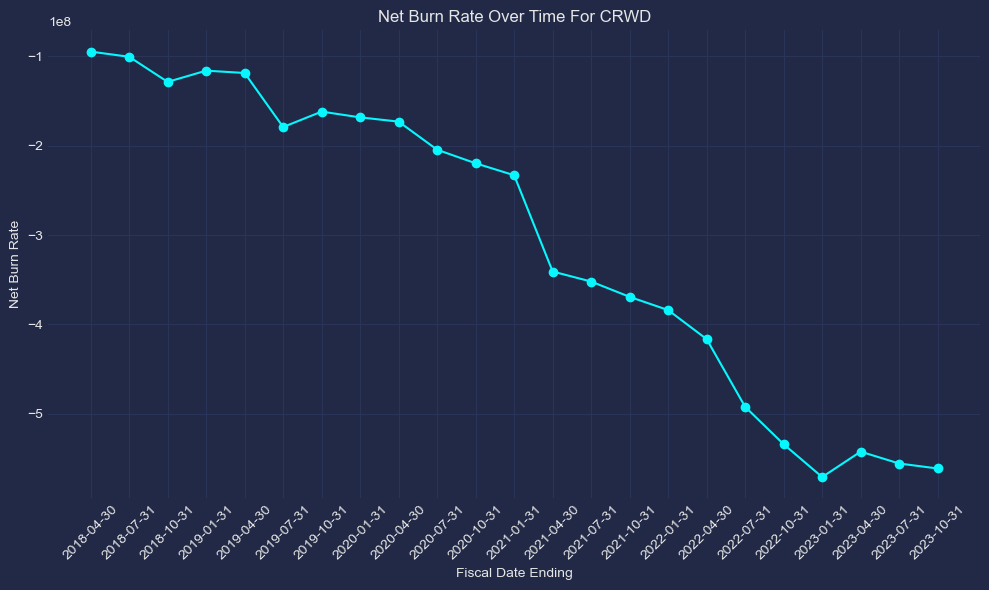

In [4]:
#Net Burn Rate
#Create function that generates burn rate chart


#input from list or manual


import pandas as pd
import yfinance as yf

#plots individual table and chart for net burn rate
import requests
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import mplcyberpunk

load_dotenv()

plt.style.use("cyberpunk")

def plot_net_burn_rate(symbol):
    load_dotenv(dotenv_path='a.env')
    
    vantage_key = os.environ['VANTAGE_KEY']
    
    url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={symbol}&apikey={vantage_key}'
    r = requests.get(url)
    data = r.json()
    
    income_statement = data['quarterlyReports']
    df = pd.DataFrame(income_statement)
    
    numeric_cols = ['netIncome', 'operatingExpenses']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    df['netBurnRate'] = df['netIncome'] - df['operatingExpenses']
    
    print(df[['fiscalDateEnding', 'netBurnRate']])
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['fiscalDateEnding'], df['netBurnRate'], marker='o')
    plt.xlabel('Fiscal Date Ending')
    plt.ylabel('Net Burn Rate')
    plt.title(f'Net Burn Rate Over Time For {symbol}')
    plt.xticks(rotation=45)
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()

# List of stock tickers
stock_tickers = ['CRWD']  # Add more as needed

for symbol in stock_tickers:
    plot_net_burn_rate(symbol)



Profitability Ratio Analysis under wraps for the time being.

News Sentiment Analysis under wraps for the time being